<a href="https://colab.research.google.com/github/spyrosviz/Greek_Football_League_Analysis_2020_2021/blob/main/Greek_Football_League_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Greek football league 2020-2021 analysis**

## **1 Analysis on whole league**

### **1.1 Find Total Bookmakers Accuracy**

In [157]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
!pip install bioinfokit
from bioinfokit.visuz import cluster
import seaborn as sns

In [158]:
# Import csv file of greek football league outcomes from 2020-2021 season (file was found on football-data.co.uk)

df = pd.read_csv(r'/content/drive/MyDrive/Greek_Football_League_Analysis/greekfootball_2020_2021.csv')

# Compute outcome probabilities from odds columns and add new columns in the dataframe
df['WinHomeProb'] = (1/df['B365H'])/((1/df['B365D']) + (1/df['B365A']) +(1/df['B365H']))
df['DrawProb'] = (1/df['B365D'])/((1/df['B365D']) + (1/df['B365A']) +(1/df['B365H']))
df['WinAwayProb'] = (1/df['B365A'])/((1/df['B365D']) + (1/df['B365A']) +(1/df['B365H']))

# Replace true outcomes column values (FTR) with 0 for D (draw), 1 for H (home win) and 2 for A (away win)
df['FTR'].replace(['D','H','A'],[0,1,2],inplace=True)

print(df.head(5))
print(df['FTR'].values)

  Div        Date   Time  ... WinHomeProb  DrawProb  WinAwayProb
0  G1  11/09/2020  16:15  ...    0.629213  0.235955     0.134831
1  G1  11/09/2020  18:30  ...    0.781250  0.156250     0.062500
2  G1  12/09/2020  16:00  ...    0.529632  0.267931     0.202437
3  G1  13/09/2020  16:30  ...    0.565220  0.252779     0.182001
4  G1  13/09/2020  18:30  ...    0.338872  0.295146     0.365982

[5 rows x 108 columns]
[1 1 0 2 1 0 1 2 2 2 0 1 0 0 1 0 0 2 1 1 0 1 2 1 1 1 0 2 0 0 2 0 1 2 1 1 2
 0 2 1 2 1 1 2 0 2 2 2 0 0 1 1 2 1 2 0 0 2 1 1 2 2 0 2 0 1 2 1 1 2 1 0 2 1
 2 2 0 1 1 0 2 2 1 1 0 0 0 1 2 0 1 1 1 2 1 0 2 1 1 1 2 1 2 0 1 0 2 0 2 1 1
 2 1 2 0 2 1 1 2 1 2 2 0 0 2 1 2 2 1 1 0 0 1 0 2 2 1 2 2 0 1 2 2 2 0 1 0 2
 1 2 2 2 0 0 1 1 1 0 1 2 1 1 1 0 1 0 2 2 0 1 1 1 0 1 1 1 1 2 0 2 1 1 2 0 1
 2 0 1 1 0 1 0 0 1 1 2 1 0 2 2 0 1 2 0 1 0 2 1 1 0 1 2 0 2 2 0 0 0 1 0 0 0
 2 2 2 1 1 0 2 0 0 1 2 1 0 0 1 2 2 2]


In [159]:
# Make a new column for predicted outcome, resulting from probabilities columns

pred_probs = []

for x, y, z in zip(df['DrawProb'].values,df['WinHomeProb'].values,df['WinAwayProb'].values):
  array = np.array([x,y,z])
  pred_outcome = np.argmax(array)
  pred_probs.append(pred_outcome)

df['Pred_Outcomes'] = pred_probs

# Set y_pred and y_true in order to check bookmakers accuracy

y_pred = df['Pred_Outcomes'].values
y_true = df['FTR'].values

In [160]:
# Create function to prettify confusion matrix results

def plot_confusion_matrix(y_true,y_pred,class_names,figsize=(10,10),text_size=15):

    # create the confusion matrix
    cm = confusion_matrix(y_true,y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis] # normalize confusion matrix
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    matrix_plot = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(matrix_plot)

    # Set labels to be classes
    if class_names:
        labels = class_names
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title='Confusion Matrix',
           xlabel = 'Predicted Label',
           ylabel = 'True Label',
           xticks = np.arange(n_classes),
           yticks = np.arange(n_classes),
           xticklabels = labels,
           yticklabels = labels)

    # Set x axis labels to bottom
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,f'{cm[i,j]} ({cm_norm[i,j] * 100:.1f}%)',
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black',
                 size = text_size)

Bookmakers accuracy is 0.475


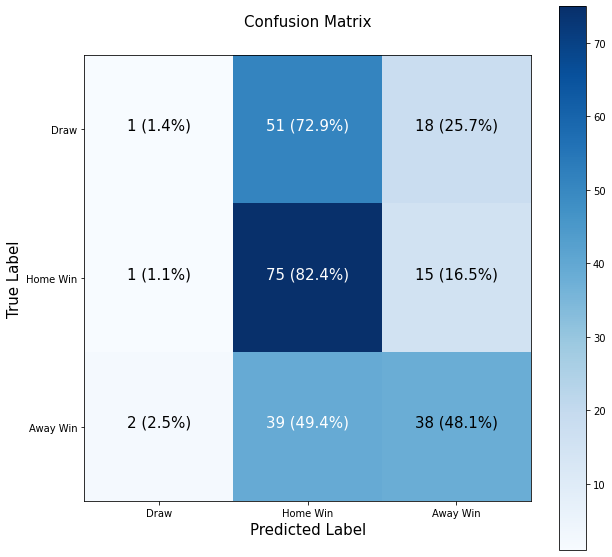

In [161]:
# Check accuracy and confusion matrix

accuracy = accuracy_score(y_true,y_pred)
print(f'Bookmakers accuracy is {accuracy}')

plot_confusion_matrix(y_true,y_pred,['Draw','Home Win','Away Win'])

In [162]:
# Make a new column where 1 if bookmakers prediction was right and 0 if it was wrong

df['Correct_False_Predictions'] = np.where(df['Pred_Outcomes']==df['FTR'],1,0)
print(df['Correct_False_Predictions'].values)

# See the mean of other variables grouped by Correct and False Bookmakers Predictions

df.groupby('Correct_False_Predictions').mean()

[1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1
 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1
 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0
 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1
 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0
 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0]


,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,...,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,WinHomeProb,DrawProb,WinAwayProb,Pred_Outcomes
Correct_False_Predictions,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.817460,1.111111,0.777778,0.293651,0.476190,7.380952,6.97619,3.698413,3.523810,17.587302,18.444444,4.563492,3.761905,2.555556,2.809524,0.119048,0.126984,2.615122,3.364959,3.715203,2.589837,3.279268,3.671220,2.687520,3.302000,3.742480,2.720965,3.367368,3.923772,2.672521,3.263950,3.779916,2.645897,3.287778,3.708205,2.810800,3.543200,4.007200,2.628640,3.309840,...,3.547778,2.812619,3.232540,3.640794,2.875476,3.260159,3.748254,2.796429,3.183175,3.634841,2.765714,3.220079,3.554762,3.021032,3.484365,3.960000,2.756111,3.216587,3.545079,2.412778,1.575476,2.460635,1.591667,2.537857,1.663254,2.391032,1.583413,-0.154762,1.920081,1.925645,1.936190,1.927619,2.006587,2.000952,1.913651,1.912460,0.416065,0.282363,0.301573,1.238095
1,1.535088,0.973684,1.324561,0.552632,0.535088,8.043860,6.45614,4.201754,3.385965,17.903509,17.877193,4.342105,3.622807,2.245614,2.500000,0.052632,0.087719,3.036726,4.152566,5.435221,2.982857,4.094464,5.193036,3.069474,4.004386,5.360088,3.142569,4.261651,5.729725,3.166126,3.990541,5.769640,3.072342,3.972973,5.465315,3.285526,4.434561,6.009211,2.990877,4.064474,...,5.168333,3.077018,3.982895,5.565088,3.210175,4.172456,5.917632,3.157544,3.922807,5.934298,3.060965,3.917193,5.461579,3.409386,4.393246,6.994474,3.022719,3.991140,5.385702,2.206491,1.731754,2.238596,1.757018,2.315000,1.822456,2.188070,1.735088,-0.359649,1.935676,1.910541,1.948421,1.911491,2.024561,1.987193,1.927632,1.897105,0.462975,0.241094,0.295932,1.324561


### **1.2 Find bookmakers accuracy on each outcome (win,loss,draw) grouped by each individual team**

In [163]:
# Make a new dataframe with all teams wins-losses, home-away and match statistics

df_teams = pd.DataFrame()

# Iterate over rows in the original dataframe and add each team from each match individually, as well as the win-loss and home-away
for index,row in df.iterrows():
  ht = row['HomeTeam']
  at = row['AwayTeam']
  win_home_prob = row['WinHomeProb']
  win_away_prob = row['WinAwayProb']
  draw_prob = row['DrawProb']
  htgf = row['FTHG']
  atgf = row['FTAG']
  # If result draw home team result and away team result is 0, if win result is 1 if loss result is 2
  ht_res = 0
  at_res = 0
  # if home team wins
  if row['FTR'] == 1:
    ht_res += 1
    at_res += 2
  # if away team wins
  elif row['FTR'] == 2:
    at_res += 1
    ht_res += 2
  # if draw
  else:
    ht_res = 0
    at_res = 0

  # If predicted outcome is home win
  ht_pred = 0
  at_pred = 0
  if row['Pred_Outcomes'] == 1:
    ht_pred += 1
    at_pred += 2
  elif row['Pred_Outcomes'] == 2:
    at_pred += 1
    ht_pred += 2
  else:
    ht_pred = 0
    at_pred = 0 

  dictionary = {'Team':[ht,at],'Opponent':[at,ht],'Result':[ht_res,at_res],'Predicted_Outcome':[ht_pred,at_pred],'Win_Probability':[win_home_prob,win_away_prob],'Loss_Probability':[win_away_prob,win_home_prob],
                'Draw_Probability':[draw_prob,draw_prob],'Goals_For':[htgf,atgf],'Goals_Against':[atgf,htgf],'Home/Away':['Home','Away'],'Shots':[row['HS'],row['AS']],'Shots_on_target':[row['HST'],row['AST']],
                'Corners':[row['HC'],row['AC']],'Fouls':[row['HF'],row['AF']],'Yellow_Cards':[row['HY'],row['AY']],'Red_Cards':[row['HR'],row['AR']]}

  df_temp = pd.DataFrame(dictionary)
  df_teams = df_teams.append(df_temp,ignore_index=True)
print(df_teams.head(10))

               Team          Opponent  Result  ...  Fouls  Yellow_Cards  Red_Cards
0              Aris             Lamia       1  ...     15             4          0
1             Lamia              Aris       2  ...     26             2          0
2              PAOK            Larisa       1  ...     21             4          0
3            Larisa              PAOK       2  ...     14             4          0
4         OFI Crete       Panetolikos       0  ...     28             5          0
5       Panetolikos         OFI Crete       0  ...     28             1          0
6         Atromitos         Volos NFC       2  ...     13             3          1
7         Volos NFC         Atromitos       1  ...     22             5          0
8  Asteras Tripolis     Panathinaikos       1  ...     14             3          0
9     Panathinaikos  Asteras Tripolis       2  ...     18             4          0

[10 rows x 16 columns]


In [164]:
'''Find the number and percentage of wins losses and draws, bookmaker predicted right, grouped by individual team'''

df_wins = df_teams[df_teams['Result']==1].copy()
df_wins['perc_correct_pred_wins'] = np.where(df_wins['Result']==df_wins['Predicted_Outcome'],1,0)
print(df_wins[['Team','perc_correct_pred_wins']].groupby('Team').mean().sort_values(by='perc_correct_pred_wins',ascending=False))

df_loss = df_teams[df_teams['Result']==2].copy()
df_loss['perc_correct_pred_losses'] = np.where(df_loss['Result']==df_loss['Predicted_Outcome'],1,0)
print(df_loss[['Team','perc_correct_pred_losses']].groupby('Team').mean().sort_values(by='perc_correct_pred_losses',ascending=False))

df_draw = df_teams[df_teams['Result']==0].copy()
df_draw['perc_correct_pred_draws'] = np.where(df_draw['Result']==df_draw['Predicted_Outcome'],1,0)
print(df_draw[['Team','perc_correct_pred_draws']].groupby('Team').mean().sort_values(by='perc_correct_pred_draws',ascending=False))

df_teams['perc_total_correct_predictions'] = np.where(df_teams['Result']==df_teams['Predicted_Outcome'],1,0)
print(df_teams[['Team','perc_total_correct_predictions']].groupby('Team').mean().sort_values(by='perc_total_correct_predictions',ascending=False))

                  perc_correct_pred_wins
Team                                    
Olympiakos                      1.000000
PAOK                            0.888889
AEK                             0.882353
Aris                            0.764706
Panetolikos                     0.666667
Panathinaikos                   0.642857
OFI Crete                       0.625000
Apollon                         0.444444
Giannina                        0.444444
Asteras Tripolis                0.416667
Volos NFC                       0.400000
Atromitos                       0.375000
Lamia                           0.250000
Larisa                          0.166667
                  perc_correct_pred_losses
Team                                      
Lamia                             0.928571
Volos NFC                         0.900000
Asteras Tripolis                  0.888889
Panetolikos                       0.764706
Larisa                            0.722222
Apollon                           0.705882


#### **Interpretation example on first team showed in Losses dataframe: Bookmaker predicted 92.85% of Lamia's total losses right.**

### **1.3 Find how well percentage of bookmaker's predicted outcome correlates with the actual percentage of that outcome grouped by team**

#### **1.3.1 Show grouped by team dataframe**

In [165]:
'''WINS'''

# Take a slice of df_teams with just Team and Result columns
df_slice_wins = df_teams.loc[:,['Team','Result','Predicted_Outcome']].copy()

# Replace 2 (loss) with 0, in order to have win or not win in Result and Predicted_Outcome column
df_slice_wins['Result'].replace(2,0,inplace=True)
df_slice_wins['Predicted_Outcome'].replace(2,0,inplace=True)
df_grouped_perc_truewins = df_slice_wins[['Team','Result']].groupby('Team').mean()
df_grouped_sum_truewins = df_slice_wins[['Team','Result']].groupby('Team').sum()
df_grouped_perc_predwins = df_slice_wins[['Team','Predicted_Outcome']].groupby('Team').mean()
df_grouped_sum_predwins = df_slice_wins[['Team','Predicted_Outcome']].groupby('Team').sum()

# Make a new dataframe and add percentage and sum of true wins and percentage and sum of predictive wins grouped by team as new columns in the dataframe
df_grouped_w = pd.DataFrame()
df_grouped_w['Percentage_of_true_wins'] = df_grouped_perc_truewins['Result']
df_grouped_w['Percentage_of_predicted_wins'] = df_grouped_perc_predwins['Predicted_Outcome']
df_grouped_w['Sum_of_true_wins'] = df_grouped_sum_truewins['Result']
df_grouped_w['Sum_of_predicted_wins'] = df_grouped_sum_predwins['Predicted_Outcome']

'''LOSSES'''

# Take a slice of df_teams with just Team and Result columns
df_slice_loss = df_teams.loc[:,['Team','Result','Predicted_Outcome']].copy()

# Replace 1 (win) with 0, and 2 (loss) with 1 in order to have loss or not loss in Result and Predicted_Outcome column
df_slice_loss['Result'].replace([1,2],[0,1],inplace=True)
df_slice_loss['Predicted_Outcome'].replace([1,2],[0,1],inplace=True)
df_grouped_perc_trueloss = df_slice_loss[['Team','Result']].groupby('Team').mean()
df_grouped_sum_trueloss = df_slice_loss[['Team','Result']].groupby('Team').sum()
df_grouped_perc_predloss = df_slice_loss[['Team','Predicted_Outcome']].groupby('Team').mean()
df_grouped_sum_predloss = df_slice_loss[['Team','Predicted_Outcome']].groupby('Team').sum()

# Make a new dataframe and add percentage and sum of true wins and percentage and sum of predictive wins grouped by team as new columns in the dataframe
df_grouped_l = pd.DataFrame()
df_grouped_l['Percentage_of_true_losses'] = df_grouped_perc_trueloss['Result']
df_grouped_l['Percentage_of_predicted_losses'] = df_grouped_perc_predloss['Predicted_Outcome']
df_grouped_l['Sum_of_true_losses'] = df_grouped_sum_trueloss['Result']
df_grouped_l['Sum_of_predicted_losses'] = df_grouped_sum_predloss['Predicted_Outcome']

'''DRAWS'''

# Take a slice of df_teams with just Team and Result columns
df_slice_draw = df_teams.loc[:,['Team','Result','Predicted_Outcome']].copy()

# Replace 0 (draw) with 1 and replace 1 (win) and 2 (loss) with 0, in order to have draw or not draw in Result and Predicted_Outcome column
df_slice_draw['Result'].replace([0,1,2],[1,0,0],inplace=True)
df_slice_draw['Predicted_Outcome'].replace([0,1,2],[1,0,0],inplace=True)
df_grouped_perc_truedraw = df_slice_draw[['Team','Result']].groupby('Team').mean()
df_grouped_sum_truedraw = df_slice_draw[['Team','Result']].groupby('Team').sum()
df_grouped_perc_preddraw = df_slice_draw[['Team','Predicted_Outcome']].groupby('Team').mean()
df_grouped_sum_preddraw = df_slice_draw[['Team','Predicted_Outcome']].groupby('Team').sum()

# Make a new dataframe and add percentage and sum of true wins and percentage and sum of predictive wins grouped by team as new columns in the dataframe
df_grouped_d = pd.DataFrame()
df_grouped_d['Percentage_of_true_draws'] = df_grouped_perc_truedraw['Result']
df_grouped_d['Percentage_of_predicted_draws'] = df_grouped_perc_preddraw['Predicted_Outcome']
df_grouped_d['Sum_of_true_draws'] = df_grouped_sum_truedraw['Result']
df_grouped_d['Sum_of_predicted_draws'] = df_grouped_sum_preddraw['Predicted_Outcome']

print(df_grouped_w[['Percentage_of_true_wins','Percentage_of_predicted_wins']])
print(df_grouped_l[['Percentage_of_true_losses','Percentage_of_predicted_losses']])
print(df_grouped_d[['Percentage_of_true_draws','Percentage_of_predicted_draws']])

                  Percentage_of_true_wins  Percentage_of_predicted_wins
Team                                                                   
AEK                              0.472222                      0.750000
Apollon                          0.272727                      0.363636
Aris                             0.472222                      0.611111
Asteras Tripolis                 0.333333                      0.305556
Atromitos                        0.242424                      0.454545
Giannina                         0.272727                      0.333333
Lamia                            0.242424                      0.242424
Larisa                           0.181818                      0.272727
OFI Crete                        0.242424                      0.424242
Olympiakos                       0.777778                      0.944444
PAOK                             0.500000                      0.861111
Panathinaikos                    0.388889                      0

#### **Interpretation example on first team: AEK won 47.22% of games played but the bookmaker predicted that would won 75% of games played**

#### **1.3.2 Show regression plot on each outcome**

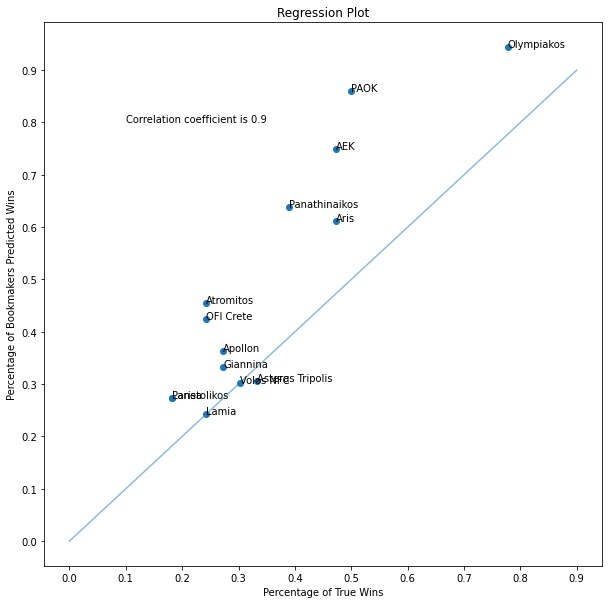

In [166]:
# Plot regression line between percentage of matches won and percentage of predicted win matches and check regression coefficient

correlation_coef_wins = round(np.corrcoef(df_grouped_w['Percentage_of_true_wins'],df_grouped_w['Percentage_of_predicted_wins'])[0][1],2)

plt.figure(figsize=[10,10])

plt.scatter(df_grouped_w['Percentage_of_true_wins'],df_grouped_w['Percentage_of_predicted_wins'])
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1),alpha=0.5)
for team in df_grouped_w.index:
    plt.annotate(team,(df_grouped_w['Percentage_of_true_wins'].loc[team],df_grouped_w['Percentage_of_predicted_wins'].loc[team]))
plt.title('Regression Plot')
plt.xlabel('Percentage of True Wins')
plt.ylabel('Percentage of Bookmakers Predicted Wins')
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
plt.annotate(f'Correlation coefficient is {correlation_coef_wins}',(0.1,0.8))
plt.show()

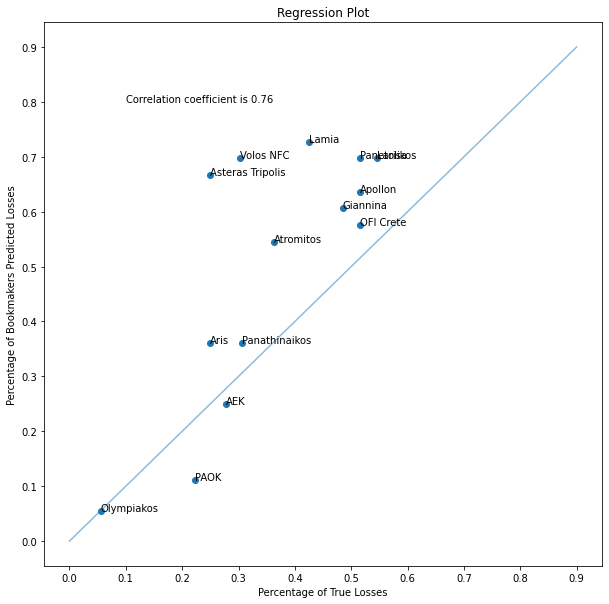

In [167]:
# Plot regression line between percentage of matches lost and percentage of predicted loss matches and check regression coefficient

correlation_coef_loss = round(np.corrcoef(df_grouped_l['Percentage_of_true_losses'],df_grouped_l['Percentage_of_predicted_losses'])[0][1],2)

plt.figure(figsize=[10,10])

plt.scatter(df_grouped_l['Percentage_of_true_losses'],df_grouped_l['Percentage_of_predicted_losses'])
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1),alpha=0.5)
for team in df_grouped_l.index:
    plt.annotate(team,(df_grouped_l['Percentage_of_true_losses'].loc[team],df_grouped_l['Percentage_of_predicted_losses'].loc[team]))
plt.title('Regression Plot')
plt.xlabel('Percentage of True Losses')
plt.ylabel('Percentage of Bookmakers Predicted Losses')
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
plt.annotate(f'Correlation coefficient is {correlation_coef_loss}',(0.1,0.8))
plt.show()

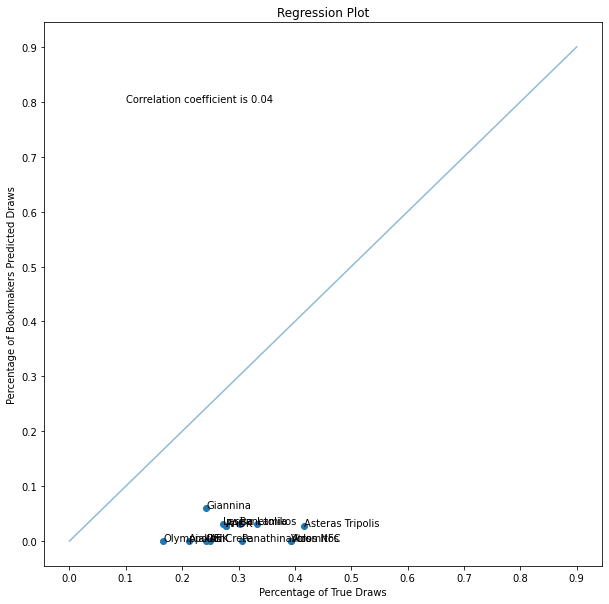

In [168]:
# Plot regression line between percentage of draw matches and percentage of predicted draw matches and check regression coefficient

correlation_coef_draw = round(np.corrcoef(df_grouped_d['Percentage_of_true_draws'],df_grouped_d['Percentage_of_predicted_draws'])[0][1],2)

plt.figure(figsize=[10,10])

plt.scatter(df_grouped_d['Percentage_of_true_draws'],df_grouped_d['Percentage_of_predicted_draws'])
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1),alpha=0.5)
for team in df_grouped_d.index:
    plt.annotate(team,(df_grouped_d['Percentage_of_true_draws'].loc[team],df_grouped_d['Percentage_of_predicted_draws'].loc[team]))
plt.title('Regression Plot')
plt.xlabel('Percentage of True Draws')
plt.ylabel('Percentage of Bookmakers Predicted Draws')
plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))
plt.annotate(f'Correlation coefficient is {correlation_coef_draw}',(0.1,0.8))
plt.show()

In [169]:
# Group mean statistics by match outcome (0:draw,1:win,2:loss)
df_teams.groupby('Result').mean()

,Predicted_Outcome,Win_Probability,Loss_Probability,Draw_Probability,Goals_For,Goals_Against,Shots,Shots_on_target,Corners,Fouls,Yellow_Cards,Red_Cards,perc_total_correct_predictions
Result,,,,,,,,,,,,,
0,1.478571,0.360528,0.360528,0.278944,0.871429,0.871429,7.071429,3.542857,4.442857,17.578571,2.385714,0.128571,0.014286
1,1.300000,0.473160,0.270989,0.255851,2.017647,0.376471,8.241176,4.764706,4.076471,18.670588,2.629412,0.058824,0.664706
2,1.647059,0.270989,0.473160,0.255851,0.376471,2.017647,6.300000,2.758824,3.776471,17.552941,2.564706,0.111765,0.664706


### **1.4 Find from given match statistics (shots,shots on target, corners, fouls, yellow cards, red cards) if they can seperate well win or not win, with Principal Component Analysis**  

In [170]:
# Set loss and draw as zero in order to make the target binary, replace Home with 1 and Away with zero

df_win_target = df_teams.copy()
df_win_target['Result'].replace(2,0,inplace=True)
df_win_target.replace('Home',1,inplace=True)
df_win_target.replace('Away',0,inplace=True)

# Drop Probabilities columns, Result and Team for X and set Result as target
selected_features = ['Home/Away','Shots','Shots_on_target','Fouls','Corners','Yellow_Cards','Red_Cards']
X = df_win_target.loc[:,selected_features].values
X_scaled = MinMaxScaler().fit_transform(X)
column_names = df_win_target.loc[:,selected_features].columns
y = df_win_target['Result'].values

print(df_win_target.head(5))

        Team     Opponent  ...  Red_Cards  perc_total_correct_predictions
0       Aris        Lamia  ...          0                               1
1      Lamia         Aris  ...          0                               1
2       PAOK       Larisa  ...          0                               1
3     Larisa         PAOK  ...          0                               1
4  OFI Crete  Panetolikos  ...          0                               0

[5 rows x 17 columns]


In [171]:
'''Construct Principal Components with PCA to reduce number of dimensions'''

pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)
pca_df = pd.DataFrame(pca_features,columns=['PCA1','PCA2','PCA3'])
target_var = []
for i in y:
  if i == 0:
    target_var.append('Loss/Draw')
  else:
    target_var.append('Win')
df_target_var = pd.DataFrame(target_var,columns=['Outcome'])
df_pca = pd.concat([pca_df,df_target_var],axis=1)
loading_scores = pca.components_
df_loadings = pd.DataFrame(loading_scores.T,columns=['PCA1','PCA2','PCA3'],index=column_names)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance,decimals=2))
df_explained_var = pd.concat([pd.DataFrame(['PCA1','PCA2','PCA3'],columns=['PC']),
                              pd.DataFrame(explained_variance,columns=['Explained Variance']),
                              pd.DataFrame(cumulative_variance,columns=['Cumulative Variance'])],axis=1)
print(df_pca)

# Define new feature set, constructed by the 3 principal components derived from PCA
X_pca = df_pca.drop(['Outcome'],axis=1).values

         PCA1      PCA2      PCA3    Outcome
0    0.536360  0.396903  0.223817        Win
1   -0.526298 -0.174513 -0.038978  Loss/Draw
2    0.554097  0.550989  0.296255        Win
3   -0.527661 -0.202586  0.091037  Loss/Draw
4    0.440005 -0.387636  0.415929  Loss/Draw
..        ...       ...       ...        ...
475 -0.469084  0.438576  0.211935        Win
476  0.524514  0.073943 -0.183760  Loss/Draw
477 -0.510788 -0.165324 -0.205840        Win
478  0.499579 -0.146940 -0.333077  Loss/Draw
479 -0.461758  0.441736 -0.045037        Win

[480 rows x 4 columns]


In [172]:
# Scree Plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_explained_var['PC'],y=df_explained_var['Explained Variance'],marker=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=df_explained_var['PC'],y=df_explained_var['Cumulative Variance'],marker=dict(size=12,color='DarkViolet')))
fig.show()

In [173]:
# PCA components 3d plot

fig = px.scatter_3d(df_pca,x='PCA1',y='PCA2',z='PCA3',color=df_pca['Outcome'])
fig.update_layout(template='plotly_dark')
fig.show()

In [174]:
# Loading scores plot

loading_scores_labels = df_loadings.index
fig = px.scatter_3d(df_loadings,x='PCA1',y='PCA2',z='PCA3',text=loading_scores_labels)
fig.show()

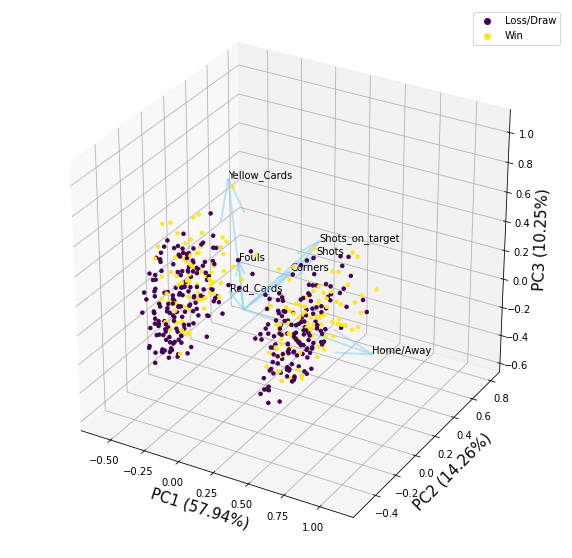

In [175]:
'''PCA Biplot'''

cluster.biplot(cscore=pca_features,loadings=loading_scores,labels=loading_scores_labels,
                var1=np.round(df_explained_var['Explained Variance'][0]*100,2),
               var2=np.round(df_explained_var['Explained Variance'][1]*100,2),
               var3=np.round(df_explained_var['Explained Variance'][2]*100,2),
               show=True,colorlist=target_var,dim=(10,10),dotsize=12,arrowlinewidth=2,axlabelfontsize=15,
               valphaarrow=0.5)

### **1.5 Find which of the above six match statistics is more important in winning with DecisionTree and Lasso**

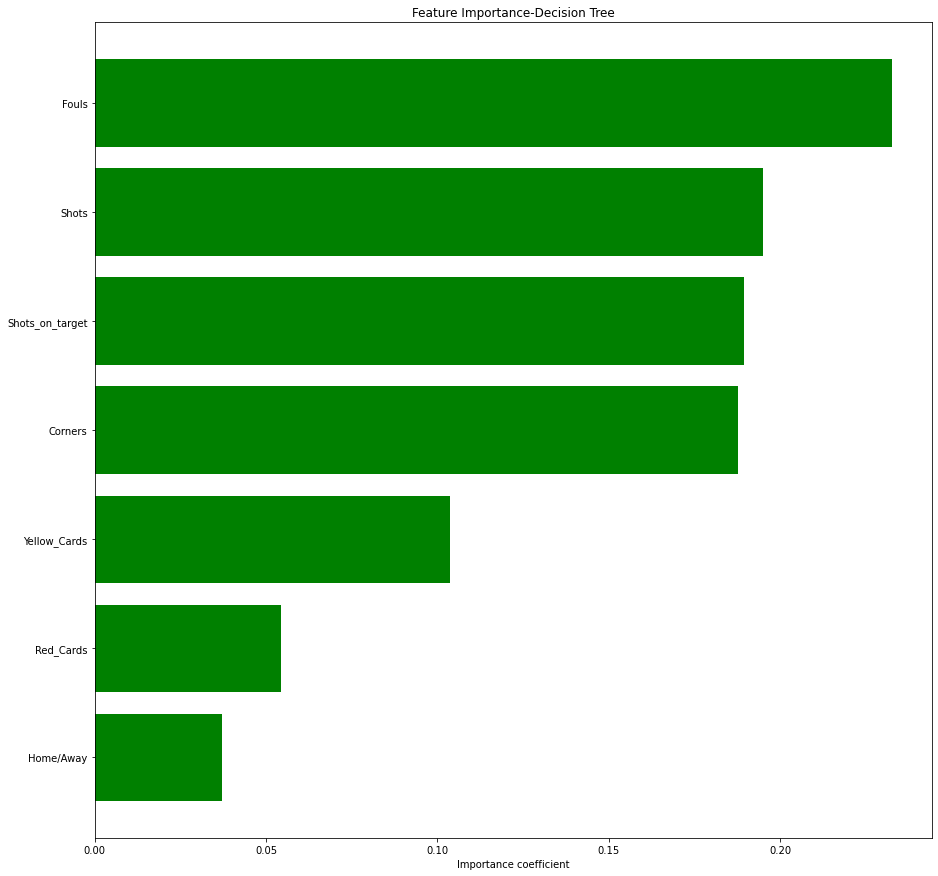

In [176]:
'''Decision Tree'''

# use decision tree to find feature importance coefficients
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X,y)
best_features = dec_tree.feature_importances_
index = np.argsort(best_features)

# plot decision tree feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(index)),best_features[index],color ="g",align="center")
plt.yticks(range(len(index)),[column_names[i] for i in index])
plt.title("Feature Importance-Decision Tree")
plt.xlabel("Importance coefficient")
plt.show()

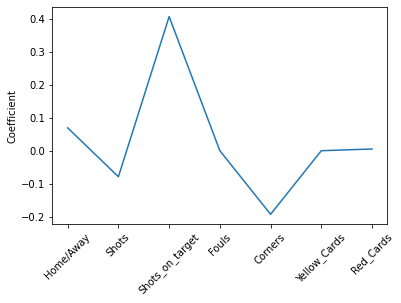

In [177]:
# LASSO Feature Importance

lasso = Lasso(alpha=0.005)
lasso.fit(X_scaled,y)

plt.plot(range(len(column_names)),coef)
plt.xticks(range(len(column_names)),column_names,rotation=45)
plt.ylabel("Coefficient")
plt.show()

## **2 Select a specific team for analysis**

In [178]:
# Select the slice of the teams_df containing only data of the selected team

selected_team = 'Panathinaikos'
df_team = df_teams[df_teams['Team']==selected_team]
df_team.replace('Home',1,inplace=True)
df_team.replace('Away',0,inplace=True)
df_team_match_stats = df_team[['Team','Opponent','Result','Home/Away','Shots','Shots_on_target','Fouls','Corners','Yellow_Cards','Red_Cards','Goals_For','Goals_Against']]
print(df_team_match_stats)

              Team          Opponent  ...  Goals_For  Goals_Against
9    Panathinaikos  Asteras Tripolis  ...          0              1
31   Panathinaikos            Larisa  ...          1              1
34   Panathinaikos              Aris  ...          0              1
53   Panathinaikos         OFI Crete  ...          2              2
62   Panathinaikos         Volos NFC  ...          1              1
77   Panathinaikos             Lamia  ...          2              0
84   Panathinaikos           Apollon  ...          1              0
90   Panathinaikos         Atromitos  ...          0              1
101  Panathinaikos        Olympiakos  ...          0              1
116  Panathinaikos       Panetolikos  ...          2              1
139  Panathinaikos               AEK  ...          2              1
146  Panathinaikos          Giannina  ...          2              0
167  Panathinaikos              PAOK  ...          1              2
172  Panathinaikos  Asteras Tripolis  ...       

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### **2.1 Find mean match statistics grouped by match outcome**

In [179]:
# Print mean statistics grouped by outcome

print(df_team_match_stats.groupby('Result').mean())

        Home/Away     Shots  ...  Goals_For  Goals_Against
Result                       ...                          
0        0.454545  6.090909  ...   0.909091       0.909091
1        0.571429  5.928571  ...   1.928571       0.428571
2        0.454545  6.181818  ...   0.363636       1.636364

[3 rows x 9 columns]


### **2.2 Find mean match statistics per outcome grouped by opponent**

In [180]:
# Print mean statistics grouped by opponent

df_when_win = df_team_match_stats[df_team_match_stats['Result']==1].copy()
print(df_when_win.groupby('Opponent').mean())

df_when_loss = df_team_match_stats[df_team_match_stats['Result']==2].copy()
print(df_when_loss.groupby('Opponent').mean())

df_when_draw = df_team_match_stats[df_team_match_stats['Result']==0].copy()
print(df_when_draw.groupby('Opponent').mean())

             Result  Home/Away  Shots  ...  Red_Cards  Goals_For  Goals_Against
Opponent                               ...                                     
AEK             1.0        0.0    7.0  ...        0.0        2.0            1.0
Apollon         1.0        0.5    3.5  ...        1.0        1.0            0.0
Aris            1.0        0.0    5.0  ...        0.0        1.0            0.0
Atromitos       1.0        0.0    6.0  ...        0.0        3.0            2.0
Giannina        1.0        1.0    8.0  ...        0.0        2.0            0.0
Lamia           1.0        0.0   11.0  ...        0.0        2.0            0.0
Larisa          1.0        1.0    8.0  ...        0.0        2.0            0.0
OFI Crete       1.0        1.0    8.0  ...        0.0        2.0            0.0
Olympiakos      1.0        1.0    5.0  ...        0.0        2.0            1.0
PAOK            1.0        1.0    4.0  ...        0.0        2.5            0.5
Panetolikos     1.0        1.0    5.0  .

### **2.3 Find mean match statistics grouped by outcome when a specific opponent is specified**

In [181]:
# Print mean statistics when selected opponent

selected_opponent = 'PAOK'
df_oppon = df_team_match_stats[df_team_match_stats['Opponent']==selected_opponent].copy()
print(df_oppon.groupby('Result').mean())

        Home/Away  Shots  Shots_on_target  ...  Red_Cards  Goals_For  Goals_Against
Result                                     ...                                     
0             0.0    3.0              0.0  ...        0.0        0.0            0.0
1             1.0    4.0              2.5  ...        0.0        2.5            0.5
2             0.0    7.0              3.0  ...        0.0        1.0            2.0

[3 rows x 9 columns]


### **Find most important features when winning with DecisionTree and Lasso**

In [182]:
# Set target variable binary (win or not win), replace Home with 1 and Away with zero
df_team['Result'].replace(2,0,inplace=True)
selected_features = ['Home/Away','Shots','Shots_on_target','Fouls','Corners','Yellow_Cards','Red_Cards']
X = df_team.loc[:,selected_features].values
X_scaled = MinMaxScaler().fit_transform(X)
column_names = df_team.loc[:,selected_features].columns
y = df_team['Result'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



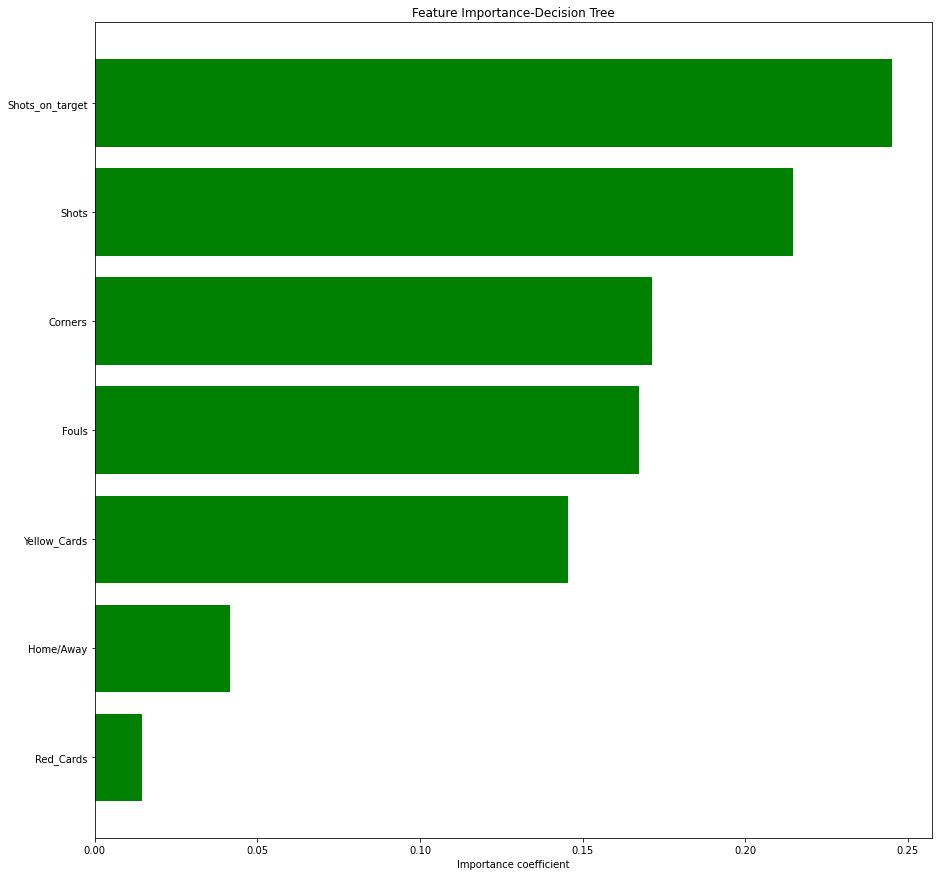

In [183]:
'''Decision Tree'''

# use decision tree to find feature importance coefficients
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X,y)
best_features = dec_tree.feature_importances_
index = np.argsort(best_features)

# plot decision tree feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(index)),best_features[index],color ="g",align="center")
plt.yticks(range(len(index)),[column_names[i] for i in index])
plt.title("Feature Importance-Decision Tree")
plt.xlabel("Importance coefficient")
plt.show()

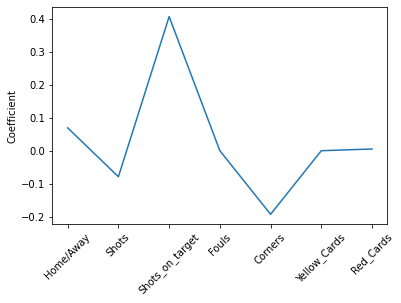

In [184]:
# LASSO Feature Importance

lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled,y)
coef = lasso.coef_

plt.plot(range(len(column_names)),coef)
plt.xticks(range(len(column_names)),column_names,rotation=45)
plt.ylabel("Coefficient")
plt.show()